In [2]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from skimage.io import imread

from unet_2d_res import *

sys.path.append("../")
from preprocess_helpers import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load Trained Model

In [21]:
MODEL_NAME = 'unet_lidc_4.hdf5'

model = unet_2d_res()
model.load_weights(MODEL_NAME)

# Load Data

In [4]:
X_train = np.array([
    imread(f'data/train/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/train/image/')
])
y_train = np.array([
    imread(f'data/train/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/train/label/')
])

X_test = np.array([
    imread(f'data/test/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/test/image/')
])
y_test = np.array([
    imread(f'data/test/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/test/label/')
])


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5513, 256, 256, 1)
(5513, 256, 256, 1)
(138, 256, 256, 1)
(138, 256, 256, 1)


# Metrics

In [5]:
def image_recall(y_true, y_pred):
    y_pred = np.round(y_pred)
    tp = np.sum(y_true*y_pred)
    fn = np.sum(np.clip(y_true - y_pred, 0, 1))
    return np.mean(tp / (tp + fn))

In [6]:
def image_precision(y_true, y_pred):
    y_pred = np.round(y_pred)
    tp = np.sum(y_true*y_pred)
    fp = np.sum(np.clip(y_pred - y_true, 0, 1))
    return np.mean(tp / (tp + fp))

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = np.round(y_pred)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return np.mean((2. * intersection + smooth) / (union + smooth))

In [8]:
def get_most_activated_roi(y_pred_mask):
    y_pred_mask = y_pred_mask.reshape(256, 256)
    blobs = y_pred_mask > .05
    blobs_labels = measure.label(blobs, background=0)
    labels = np.unique(blobs_labels)[1:]
    activations = []
    for label in labels:
        blob_activation = 0
        idxs = np.argwhere(blobs_labels==label)
        for idx_x, idx_y in idxs: 
            blob_activation += y_pred_mask[idx_x][idx_y]
        activations.append(blob_activation)
    max_region = np.argwhere(blobs_labels == np.argmax(activations) + 1).T
    x_center = int(max_region[0].mean())
    y_center = int(max_region[1].mean())
    return [(x_center-16, y_center-16), (x_center+16, y_center+16)]

def get_grouped_nodule_coords(y_true_mask):
    y_true_mask = y_true_mask.reshape(256, 256)
    blobs = y_true_mask == 1
    blobs_labels = measure.label(blobs, background=0)
    labels = np.unique(blobs_labels)[1:]
    return [np.argwhere(blobs_labels == l) for l in labels]

def percent_included(y_true, y_pred):
    if np.count_nonzero(np.round(y_pred)) == 0:
        return 0
    predicted_roi = get_most_activated_roi(y_pred)
    mask_groups_coords = get_grouped_nodule_coords(y_true)
    
    xmin, ymin = predicted_roi[0]
    xmax, ymax = predicted_roi[1]
    
    percentages = []
    for coords in mask_groups_coords:
        count = 0
        for xi, yi in coords:
            if xi >= xmin and xi < xmax and yi >= ymin and yi < ymax:
                count += 1
        percentages.append(count/len(coords))
    return max(percentages)

# Predict

### Train example

582


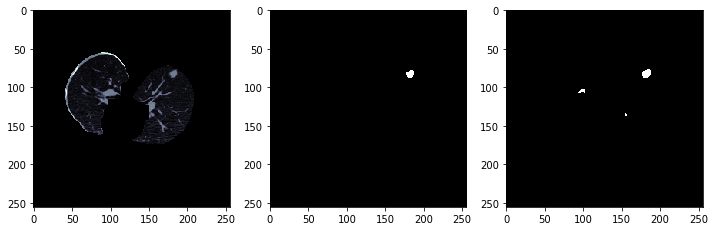

Recall 1.0
Precision 0.5793103575706482
Dice coefficient 0.7347826086956522
Percent included in ROI 1.0


In [11]:
idx = np.random.randint(len(os.listdir('data/train/image')))
print(idx)

y_hat = model.predict(X_train[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 16))
axs[0].imshow(X_train[idx].reshape(256, 256), cmap='bone')
axs[1].imshow(y_train[idx].reshape(256, 256), cmap='bone')
axs[2].imshow(y_hat.reshape(256, 256), cmap='bone')

plt.show()

print(f"Recall {image_recall(y_train[idx], y_hat[0])}")
print(f"Precision {image_precision(y_train[idx], y_hat[0])}")
print(f"Dice coefficient {dice_coef(y_train[idx], y_hat[0])}")
print(f"Percent included in ROI {percent_included(y_train[idx], y_hat[0])}")

### Test example

127


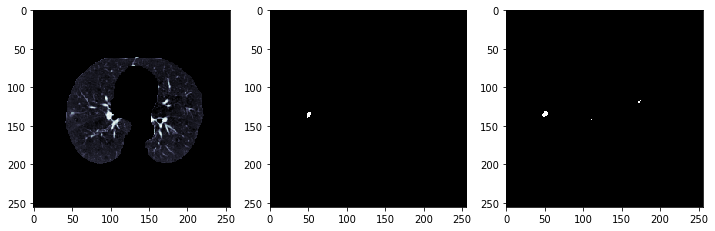

Recall 0.931034505367279
Precision 0.5192307829856873
Dice Coefficient 0.6707317073170732
Percent included in ROI 1.0


In [12]:
idx = np.random.randint(len(os.listdir('data/test/image')))
print(idx)

y_hat = model.predict(X_test[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 16))
axs[0].imshow(X_test[idx].reshape(256, 256), cmap='bone')
axs[1].imshow(y_test[idx].reshape(256, 256), cmap='bone')
axs[2].imshow(y_hat.reshape(256, 256), cmap='bone')
plt.show()

threshold = y_hat[0].max()/2

print(f"Recall {image_recall(y_test[idx], y_hat[0])}")
print(f"Precision {image_precision(y_test[idx], y_hat[0])}")
print(f"Dice Coefficient {dice_coef(y_test[idx], y_hat[0])}")
print(f"Percent included in ROI {percent_included(y_test[idx], y_hat[0])}")

### Train Overall

In [22]:
train_recall = []
train_precision = []
train_dice = []
train_percent_included = []

for i in range(len(X_train)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_train[[i]])
    train_recall.append(image_recall(y_train[i], y_hat[0]))
    train_precision.append(image_precision(y_train[i], y_hat[0]))
    train_dice.append(dice_coef(y_train[i], y_hat[0]))
    train_percent_included.append(percent_included(y_train[i], y_hat[0]))

train_recall = np.array(train_recall)
train_precision = np.array(train_precision)
train_precision = train_precision[np.logical_not(np.isnan(train_precision))]
train_dice = np.array(train_dice)
train_percent_included = np.array(train_percent_included)

print()
print(np.array(f"Training set average recall: {train_recall.mean()}"))
print(np.array(f"Training set average precision: {train_precision.mean()}"))
print(np.array(f"Training set average dice coefficient: {train_dice.mean()}"))
print(np.array(f"Training set average percent included in ROI: {train_percent_included.mean()}"))

5512
Training set average recall: 0.34742510318756104
Training set average precision: 0.5914859175682068
Training set average dice coefficient: 0.38451326685021064
Training set average percent included in ROI: 0.4561614607915081


### Test Overall

In [23]:
test_recall = []
test_precision = []
test_dice = []
test_percent_included = []

for i in range(len(X_test)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_test[[i]])
    test_recall.append(image_recall(y_test[i], y_hat[0]))
    test_precision.append(image_precision(y_test[i], y_hat[0]))
    test_dice.append(dice_coef(y_test[i], y_hat[0]))
    test_percent_included.append(percent_included(y_test[i], y_hat[0]))

        
test_recall = np.array(test_recall)
test_precision = np.array(test_precision)
test_precision = test_precision[np.logical_not(np.isnan(test_precision))]
test_dice = np.array(test_dice)
test_percent_included = np.array(test_percent_included)

print()
print(np.array(f"Test set recall: {test_recall.mean()}"))
print(np.array(f"Test set precision: {test_precision.mean()}"))
print(np.array(f"Test set dice coefficient: {test_dice.mean()}"))
print(np.array(f"Test set average percent included in ROI: {test_percent_included.mean()}"))

137
Test set recall: 0.45417729020118713
Test set precision: 0.7192412614822388
Test set dice coefficient: 0.4786715652972698
Test set average percent included in ROI: 0.6041036160841149
